In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd /content/gdrive/My\ Drive/Game\ of\ Deep\ Learning/images/

/content/gdrive/My Drive/Game of Deep Learning/images


In [3]:
!find . -type f | wc -l

8932


In [4]:
cd /content/gdrive/My\ Drive/Game\ of\ Deep\ Learning/

/content/gdrive/My Drive/Game of Deep Learning


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import tqdm

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test_ApKoW4T.csv')

In [0]:
PATH = "./images/"

In [8]:
train.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [9]:
test.head()

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg


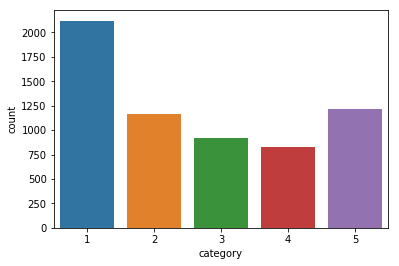

In [10]:
sns.countplot(x="category", data=train),
plt.show()

In [11]:
train['category'].value_counts()

1    2120
5    1217
2    1167
3     916
4     832
Name: category, dtype: int64

In [12]:
train.isnull().sum()

image       0
category    0
dtype: int64

In [13]:
test.isnull().sum()

image    0
dtype: int64

In [0]:
temp = []
for i in range (len(train['category'])):
  local = str(train['category'][i])
  temp.append(local)
train.insert(2, "String_category", temp)

In [15]:
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

A sample image from training set



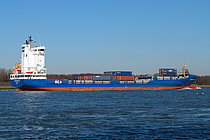

In [17]:
from IPython.display import Image

print("A sample image from training set\n")
Image(filename = PATH + train["image"][0], width=224, height=224)

A sample image from validation set



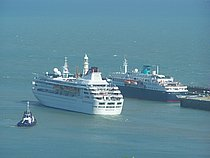

In [18]:
print("A sample image from validation set\n")
Image(filename = PATH + train["image"][5006], width=224, height=224)

A sample image from test set



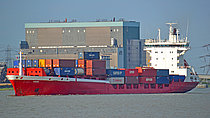

In [19]:
print("A sample image from test set\n")
Image(filename = PATH + test["image"][2000], width=224, height=224)

In [0]:
batch_size = 16

In [21]:
train_generator = datagen.flow_from_dataframe(dataframe=train[:5000], directory="./images/",
                                            x_col="image", y_col="String_category", batch_size=batch_size, shuffle=True, class_mode="categorical", target_size=(224,224))
valid_generator = datagen.flow_from_dataframe(dataframe=train[5000:], directory="./images/",
                                            x_col="image", y_col="String_category", batch_size=batch_size, shuffle=True, class_mode="categorical", target_size=(224,224))
test_generator  = datagen.flow_from_dataframe(dataframe=test, directory="./images/",
                                            x_col="image", batch_size=1, shuffle=False, class_mode=None, target_size=(224,224))

Found 5000 validated image filenames belonging to 5 classes.
Found 1252 validated image filenames belonging to 5 classes.
Found 2680 validated image filenames.


In [22]:
from keras.engine.input_layer import Input
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

base_model = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

Instructions for updating:
Colocations handled automatically by placer.


In [23]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model

plot_model(base_model, to_file='vgg16.png')

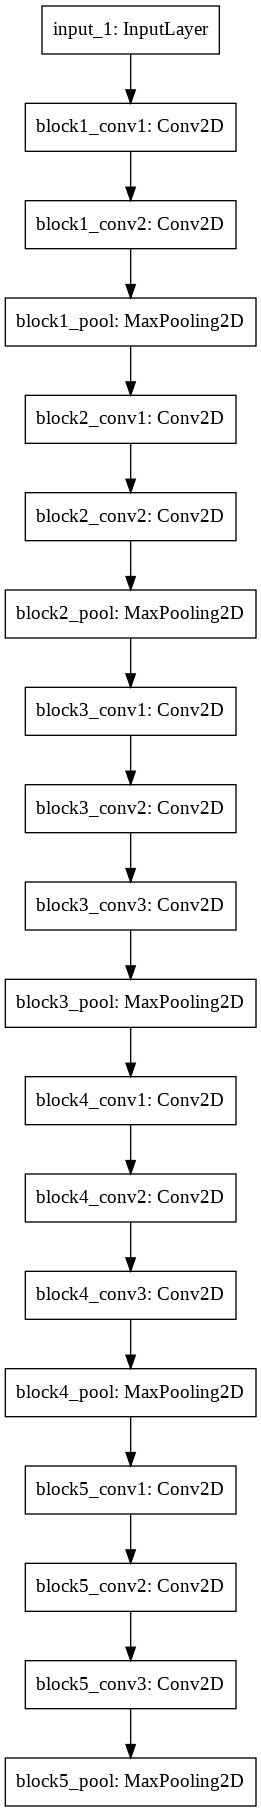

In [25]:
Image(filename = "vgg16.png")

In [26]:
from keras.layers import AveragePooling2D, GlobalAveragePooling2D, multiply, Lambda
from keras.models import Model

head_model = base_model.output
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(512, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(32, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(5, activation="softmax")(head_model)

model = Model(inputs=base_model.input, outputs=head_model)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
for layer in base_model.layers:
	layer.trainable = False

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
model.compile(optimizer = Adam(lr = 1e-3, beta_1=0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = True),
              loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [31]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('VGG16(Custom-CNN).hdf5',
                monitor='val_acc', verbose=1, save_best_only=True, 
                save_weights_only=True, mode='max', period=1)

callbacks_list = [checkpoint]


history = model.fit_generator(train_generator, steps_per_epoch=5000 // batch_size, 
                              epochs=100, callbacks=callbacks_list, 
                              validation_data=valid_generator, 
                              validation_steps=1252 // batch_size)


Instructions for updating:
Use tf.cast instead.
Epoch 1/100
312/312 [==============================] - 39s 125ms/step - loss: 1.8606 - acc: 0.3219 - val_loss: 1.5786 - val_acc: 0.3229

Epoch 00001: val_acc improved from -inf to 0.32292, saving model to VGG16(Custom-CNN).hdf5
Epoch 2/100
312/312 [==============================] - 37s 118ms/step - loss: 1.5624 - acc: 0.3411 - val_loss: 1.4974 - val_acc: 0.3269

Epoch 00002: val_acc improved from 0.32292 to 0.32686, saving model to VGG16(Custom-CNN).hdf5
Epoch 3/100
312/312 [==============================] - 34s 110ms/step - loss: 1.4834 - acc: 0.3510 - val_loss: 1.4207 - val_acc: 0.3333

Epoch 00003: val_acc improved from 0.32686 to 0.33333, saving model to VGG16(Custom-CNN).hdf5
Epoch 4/100
312/312 [==============================] - 35s 111ms/step - loss: 1.4513 - acc: 0.3668 - val_loss: 1.3562 - val_acc: 0.3301

Epoch 00004: val_acc did not improve from 0.33333
Epoch 5/100
312/312 [==============================] - 35s 111ms/step - los

In [0]:
model.save('VGG(Custom-CNN)-100epochs.h5')

In [0]:
from keras.models import load_model
model.load_weights('VGG16(Custom-CNN).hdf5')

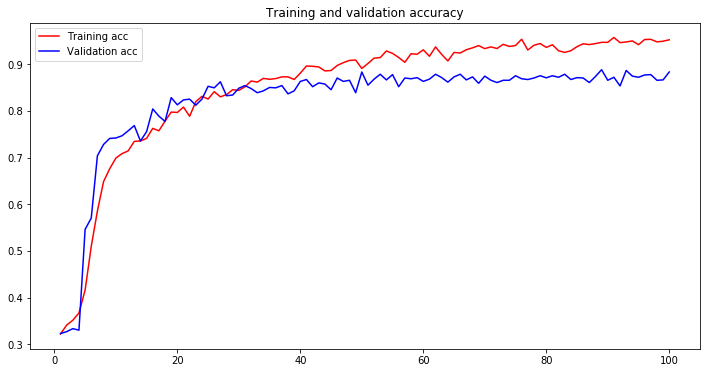

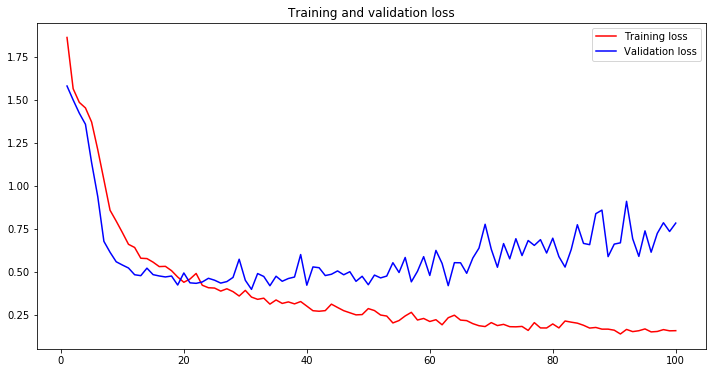

In [35]:
from keras.callbacks import *
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12,6)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()


In [36]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()

pred=model.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)

2680/2680 [==============================] - 28s 10ms/step


In [0]:
Y_test=np.argmax(pred, axis=1)
Y_test+=1

In [38]:
sub = pd.read_csv('sample_submission_ns2btKE.csv')
sub.head()

,image,category
0,1007700.jpg,1
1,1011369.jpg,1
2,1051155.jpg,1
3,1062001.jpg,1
4,1069397.jpg,1


In [39]:
sub.drop(columns = ["category"])

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg
5,1072861.jpg
6,1097264.jpg
7,1098763.jpg
8,1098766.jpg
9,1101145.jpg


In [0]:
sub.insert(1, "Category", Y_test)

In [0]:
sub.to_csv('submit_VGG(Custom-CNN)_100epochs.csv')